# Rendering Triskaidecagrams

This notebook contains a program for rendering a triskaidecagon (13-sided regular polygon), together with all its inscribed triskaidecagrams.  My approach here consciously adopts a couple of constraints. First, I compute everything with exact arithmetic, using integers rather than floating point numbers.  Second, I compute intersection points by applying proportions, rather than by intersecting lines.

## Triskaidecagon Numbers

The first section of code below contains an implementation of the triskaidecagon number field, a field derived from the diagonals of the triskaidecagram as described in Steinbach2000 and Steinbach2004.  I use $\alpha$, $\beta$, $\gamma$, $\delta$, and $\epsilon$ for the diagonals of a unit-sided triskaidecagram, in order of increasing length.  Any field element has the form $a+b\alpha+c\beta+d\gamma+e\delta+f\epsilon$, for some rational numbers $a$, $b$, $c$, $d$, and $e$.

Given the table of basic products and reciprocals below, I can scale any number or vector up or down by factors of $\alpha$, $\beta$, $\gamma$, $\delta$, and $\epsilon$.  With this ability, I don't actually require general division, so I can limit my coefficients to integers rather than rationals.

|          | $\alpha$ | $\beta$ | $\gamma$ | $\delta$ | $\epsilon$ |
|----------|----------|---------|----------|----------|
| $\alpha$ | $\alpha\alpha=1+\beta$ | $\alpha\beta=\alpha+\gamma$ | $\alpha\gamma=\beta+\delta$ | $\alpha\delta=\gamma+\epsilon$ | $\alpha\epsilon=\delta+\epsilon$ |
| $\beta$  |         | $\beta\beta=1+\beta+\delta$ | $\beta\gamma=\alpha+\gamma+\epsilon$ | $\beta\delta=\beta+\delta+\epsilon$ | $\beta\epsilon=\gamma+\delta+\epsilon$ |
| $\gamma$ |         |         | $\gamma\gamma=1+\beta+\delta+\epsilon$ | $\gamma\delta=\alpha+\gamma+\delta+\epsilon$ | $\gamma\epsilon=\beta+\gamma+\delta+\epsilon$ |
| $\delta$ |         |         |         | $\delta\delta=1+\beta+\gamma+\delta+\epsilon$ | $\delta\epsilon=\alpha+\beta+\gamma+\delta+\epsilon$ |
| $\epsilon$ |         |         |         |         | $\epsilon\epsilon=1+\alpha+\beta+\gamma+\delta+\epsilon$ |

|  ratio  | inverse |
|----------|----------|---------|----------|----------|
| $1$ | $1/\theta=1+\theta-\kappa-\lambda+\mu$ | $1/\kappa=\theta+\kappa-\lambda-1$ | $1/\lambda=\lambda-\theta-1$ | $1/\mu=\mu-\lambda$ |
| $\theta$ |         | $\theta/\kappa=1+\lambda-\mu$ | $\theta/\lambda=\lambda-\theta-1$ | $\theta/\mu=\lambda-\kappa$ |
| $\kappa$  | $\kappa/\theta=\kappa+\lambda-\mu-1$ |     | $\kappa/\lambda=\mu-\kappa$ | $\kappa/\mu=\kappa-\theta$ |
| $\lambda$ | $\lambda/\theta=\kappa-1$ | $\lambda/\kappa=\theta+\mu-\lambda-1$ |  | $\lambda/\mu=\theta-1$ |
| $\mu$ | $\mu/\theta=1+\mu-\kappa$ | $\mu/\kappa=\lambda-\theta$ | $\mu/\lambda=\theta+\kappa-\mu$ |  $ $ |

All of these products and quotients can be derived using basic geometry, by considering various similar triangles in the triskaidecagon and inscribed triskaidecagrams.  I've explained the technique in more detail with respect to the [heptagon field](http://nbviewer.ipython.org/github/vorth/ipython/blob/master/heptagons/HeptagonNumbers.ipynb).

The code below is mostly a collection of special functions, to overload arithmetic operators for the class.  This will be very important for readability of the code later in the notebook.

In [10]:
import math

class TriskaidecagonNumber(object):
    def __init__( self, ones=0, alpha=0, beta=0, gamma=0, delta=0, epsilon=0 ):
        self.ones = ones
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon

    def __add__( self, rhs ):  #self and rhs are TriskaidecagonNumber objects
        return TriskaidecagonNumber(
                self.ones+rhs.ones,
                self.alpha+rhs.alpha,
                self.beta+rhs.beta,
                self.gamma+rhs.gamma,
                self.delta+rhs.delta,
                self.epsilon+rhs.epsilon )

    def __sub__( self, rhs ):  #self and rhs are TriskaidecagonNumber objects
        return TriskaidecagonNumber(
                self.ones-rhs.ones,
                self.alpha-rhs.alpha,
                self.beta-rhs.beta,
                self.gamma-rhs.gamma,
                self.delta-rhs.delta,
                self.epsilon-rhs.epsilon )

    def __neg__( self ) :
        return TriskaidecagonNumber( -self.ones, -self.alpha, -self.beta, -self.gamma, -self.delta, -self.epsilon )

    def timesalpha( self ) :
        return TriskaidecagonNumber(
                self.alpha,
                self.ones + self.beta,
                self.alpha + self.gamma,
                self.delta + self.beta,
                self.epsilon + self.gamma,
                self.delta + self.epsilon )

    def timesbeta( self ) :
        return TriskaidecagonNumber(
                self.beta,
                self.alpha + self.gamma,
                self.ones + self.beta + self.delta,
                self.alpha + self.gamma + self.epsilon,
                self.delta + self.beta + self.epsilon,
                self.delta + self.gamma + self.epsilon )

    def timesgamma( self ) :
        return TriskaidecagonNumber(
                self.gamma,
                self.beta + self.delta,
                self.alpha + self.gamma + self.epsilon,
                self.beta + self.delta + self.ones + self.epsilon,
                self.alpha + self.gamma + self.epsilon + self.delta,
                self.beta + self.delta + self.gamma + self.epsilon )

    def timesdelta( self ) :
        return TriskaidecagonNumber(
                self.delta,
                self.gamma + self.epsilon,
                self.beta + self.delta + self.epsilon,
                self.alpha + self.gamma + self.delta + self.epsilon,
                self.ones + self.beta + self.gamma + self.delta + self.epsilon,
                self.alpha + self.beta + self.gamma + self.delta + self.epsilon )

    def timesepsilon( self ) :
        return TriskaidecagonNumber(
                self.epsilon,
                self.delta + self.epsilon,
                self.gamma + self.delta + self.epsilon,
                self.beta + self.gamma + self.delta + self.epsilon,
                self.alpha + self.beta + self.gamma + self.delta + self.epsilon,
                self.ones + self.alpha + self.beta + self.gamma + self.delta + self.epsilon )

    def __mul__( self, rhs ) :
        if isinstance( rhs, self.__class__ ):
            return ( self * rhs.ones ) .__add__(
                ( self .timesalpha() * rhs.alpha ) .__add__(
                ( self .timesbeta() * rhs.beta ) .__add__(
                ( self .timesgamma() * rhs.gamma ) .__add__(
                ( self .timesdelta() * rhs.delta ) .__add__(
                ( self .timesepsilon() * rhs.epsilon ) ) ) ) ) )
        elif isinstance( rhs, int ):
            return TriskaidecagonNumber(
                self.ones*rhs,
                self.alpha*rhs,
                self.beta*rhs,
                self.gamma*rhs,
                self.delta*rhs,
                self.epsilon*rhs )
        else:
            raise TypeError("unsupported operand type(s) for +: '{}' and '{}'").format(self.__class__, type(other))

    def __str__( self ):
        s = u""
        if self.ones != 0 :
            s = s + u"%d" % ( self.ones )
        if self.alpha != 0 :
            if len(s) > 0 :
                s = s + u"+"
            if self.alpha != 1 :
                s = s + u"%d" % ( self.alpha )
            s = s + u"\u03B1"
        if self.beta != 0 :
            if len(s) > 0 :
                s = s + u"+"
            if self.beta != 1 :
                s = s + u"%d" % ( self.beta )
            s = s + u"\u03B2"
        if self.gamma != 0 :
            if len(s) > 0 :
                s = s + u"+"
            if self.gamma != 1 :
                s = s + u"%d" % ( self.gamma )
            s = s + u"\u03B3"
        if self.delta != 0 :
            if len(s) > 0 :
                s = s + u"+"
            if self.delta != 1 :
                s = s + u"%d" % ( self.delta )
            s = s + u"\u03B4"
        if self.epsilon != 0 :
            if len(s) > 0 :
                s = s + u"+"
            if self.epsilon != 1 :
                s = s + u"%d" % ( self.epsilon )
            s = s + u"\u03B5"
        return s.encode('utf-8') 

    denom = math.sin( math.pi/13 )
    alpha_real = math.sin( 2*math.pi/13 ) / denom
    beta_real = math.sin( 3*math.pi/13 ) / denom
    gamma_real = math.sin( 4*math.pi/13 ) / denom
    delta_real = math.sin( 5*math.pi/13 ) / denom
    epsilon_real = math.sin( 6*math.pi/13 ) / denom
    
    def __float__( self ) :
        return self.ones + \
            self.alpha_real * self.alpha + \
            self.beta_real * self.beta + \
            self.gamma_real * self.gamma + \
            self.delta_real * self.delta + \
            self.epsilon_real * self.epsilon

zero    = TriskaidecagonNumber()
one     = TriskaidecagonNumber(1)
alpha   = TriskaidecagonNumber(0,1)
beta    = TriskaidecagonNumber(0,0,1)
gamma   = TriskaidecagonNumber(0,0,0,1)
delta   = TriskaidecagonNumber(0,0,0,0,1)
epsilon = TriskaidecagonNumber(0,0,0,0,0,1)

alpha_inv = alpha + beta + epsilon - delta - gamma - one
beta_inv = beta + gamma - alpha - delta
gamma_inv = one + gamma - epsilon
delta_inv = delta + gamma - one - alpha - epsilon
epsilon_inv = epsilon - delta

print str(alpha)   + " = " + str(TriskaidecagonNumber.alpha_real)
print str(beta)    + " = " + str(TriskaidecagonNumber.beta_real)
print str(gamma)   + " = " + str(TriskaidecagonNumber.gamma_real)
print str(delta)   + " = " + str(TriskaidecagonNumber.delta_real)
print str(epsilon) + " = " + str(TriskaidecagonNumber.epsilon_real)

def printProd( h1, h2 ) :
    print str(h1) + "("+ str(h2) + ") = " + str(h1*h2)
    
printProd( gamma, epsilon )
printProd( delta, beta )
printProd( gamma, gamma )
printProd( alpha, gamma )
printProd( delta, epsilon )
printProd( delta, 4 )
printProd( alpha, alpha_inv )

D = [ one for x in range(13) ]
D[2] = D[11] = alpha
D[3] = D[10] = beta
D[4] = D[9] = gamma
D[5] = D[8] = delta
D[6] = D[7] = epsilon

for i in range(13):
    print "D[" + str(i) + "] = " + str(D[i])

I = [ one for x in range(13) ]
I[2] = I[11] = alpha_inv
I[3] = I[10] = beta_inv
I[4] = I[9] = gamma_inv
I[5] = I[8] = delta_inv
I[6] = I[7] = epsilon_inv

for i in range(13):
    print "I[" + str(i) + "] = " + str(I[i])


α = 1.94188363485
β = 2.77091205131
γ = 3.43890513119
δ = 3.90704154477
ε = 4.14811490528
γ(ε) = β+γ+δ+ε
δ(β) = β+δ+ε
γ(γ) = 1+β+δ+ε
α(γ) = β+δ
δ(ε) = α+β+γ+δ+ε
δ(4) = 4δ
α(-1+α+β+-1γ+-1δ+ε) = 1
D[0] = 1
D[1] = 1
D[2] = α
D[3] = β
D[4] = γ
D[5] = δ
D[6] = ε
D[7] = ε
D[8] = δ
D[9] = γ
D[10] = β
D[11] = α
D[12] = 1
I[0] = 1
I[1] = 1
I[2] = -1+α+β+-1γ+-1δ+ε
I[3] = -1α+β+γ+-1δ
I[4] = 1+γ+-1ε
I[5] = -1+-1α+γ+δ+-1ε
I[6] = -1δ+ε
I[7] = -1δ+ε
I[8] = -1+-1α+γ+δ+-1ε
I[9] = 1+γ+-1ε
I[10] = -1α+β+γ+-1δ
I[11] = -1+α+β+-1γ+-1δ+ε
I[12] = 1


## Vectors and Rendering

The next section of code is a simple implementation of two-dimensional vectors over the triskaidecagon numbers.  The only noteworthy point here is the render function, which does two things.  First, it converts the coordinate triskaidecagon numbers to real numbers.  Next, it performs a skew transformation to map from the initial coordinate frame to the frame I need to use for drawing.  These coordinate frames are different because the first one allows a simple encoding of the triskaidecagon vertices, using a frame aligned with a diagonal of the triskaidecagon.  This simplifies all the later computations based on these vertices.  The only cost is to perform the skew transformation when it is time to render to the screen.


In [20]:

class Vector(object):

    def __init__( self, x, y ):
        self.x = x
        self.y = y

    def __mul__( self, rhs ) :
        return Vector( rhs .__mul__( self.x ), rhs .__mul__( self.y ) )

    def __add__( self, rhs ) :
        return Vector( self.x + rhs.x, self.y + rhs.y )

    def __sub__( self, rhs ) :
        return Vector( self.x - rhs.x, self.y - rhs.y )

    def __neg__( self ) :
        return Vector( -self.x, -self.y )

    def __str__( self ):
        return "[ " + str( self.x ) + ", " + str( self.y ) + " ]"

    def render( self ):
        x = float( self.x )
        y = float( self.y )
        A = math.sin( (6.0/13.0) * math.pi )
        x = float( self.x ) + float( self.y ) / (2*TriskaidecagonNumber.epsilon_real)
        y = A * float( self.y )
        return [ x, y ]

origin = Vector( zero, zero )


## Triskaidecagon Vertices

The code below defines the vertices of the triskaidecagon, then constructs lists of those vertices representing the triskaidecagon and all four of the inscribed triskaidecagrams.

In [21]:

p = [ Vector( one, zero ) for x in range(13) ]
p[0] = Vector( zero, zero )
p[1] = Vector( - delta, alpha )
p[2] = Vector( - beta - delta, alpha + gamma )
p[3] = Vector( - one - beta - delta, gamma * beta )
p[4] = Vector( - beta - delta, gamma * delta )
p[5] = Vector( - delta, delta * epsilon )
p[6] = Vector( zero, epsilon * epsilon )
p[7] = Vector( epsilon, delta * epsilon )
p[8] = Vector( gamma + epsilon, gamma * delta )
p[9] = Vector( gamma * beta, gamma * beta )
p[10] = Vector( gamma * beta, alpha + gamma )
p[11] = Vector( gamma + epsilon, alpha )
p[12] = Vector( epsilon, zero )

triskaidecagrams = [ [ p[ (n * m) % 13 ] for m in range(13) ] for n in range(7) ]

print (str(float(epsilon * epsilon)))


17.2068572674


In [42]:

import random

def diagonalIntersection( p, a, b, c, d ):
    # a, b = indices of endpoints of one diagonal
    # c, d = indices of endpoints of other diagonal
    n = len( p )
    e = ( d - a ) % n
    f = ( n - ( c + d ) + ( a + b ) ) % n
    g = ( c - a ) % n
    h = ( b - a ) % n
    return p[a] + ( p[b] - p[a] ) * D[e] * D[g] * I[f] * I[h]

def diagonalIntersectionLoop( n, used ):
    loop = []
    edges = (n-1)/2
    used = [ False for i in range(edges) ]
    a = random .randint( 0, n-1 )
    b = random .randint( a+2, n-1+a-2 ) % n
    a0 = a
    b0 = b
    print "a: " + str(a) + ", b: " + str(b)
    loop .append( ( a, b ) )
    for i in range(2,(n-1)/2):
        print "i = " + str(i)
        if ( b < a ):
            swap = b
            b = a
            a = swap
        diff = (b-a)%n
        if diff > edges:
            diff = n-diff
        used[ diff-1 ] = True
        # now a < b
        c = random .randint( a+1, b-1 ) % n
        d = random .randint( b+1, a-1+n ) % n
        print "c: " + str(c) + ", d: " + str(d)
        loop .append( ( c, d ) )
        a = c
        b = d
    return loop

def loopPoints( loop, offset, N ):
    points = []
    n = len(loop)
    for i in range( n ):
        a, b = loop[ i ]
        c, d = loop[ (i+1)%n ]
        a = ( a + offset ) % N
        b = ( b + offset ) % N
        c = ( c + offset ) % N
        d = ( d + offset ) % N
        pt = diagonalIntersection( p, a, b, c ,d )
        points .append( pt )
    return points

    

Populating the interactive namespace from numpy and matplotlib
a: 6, b: 12
i = 2
c: 11, d: 2
i = 3
c: 3, d: 1
i = 4
c: 2, d: 5
i = 5
c: 4, d: 7


(-10.0, 15.0, -5.0, 20.0)

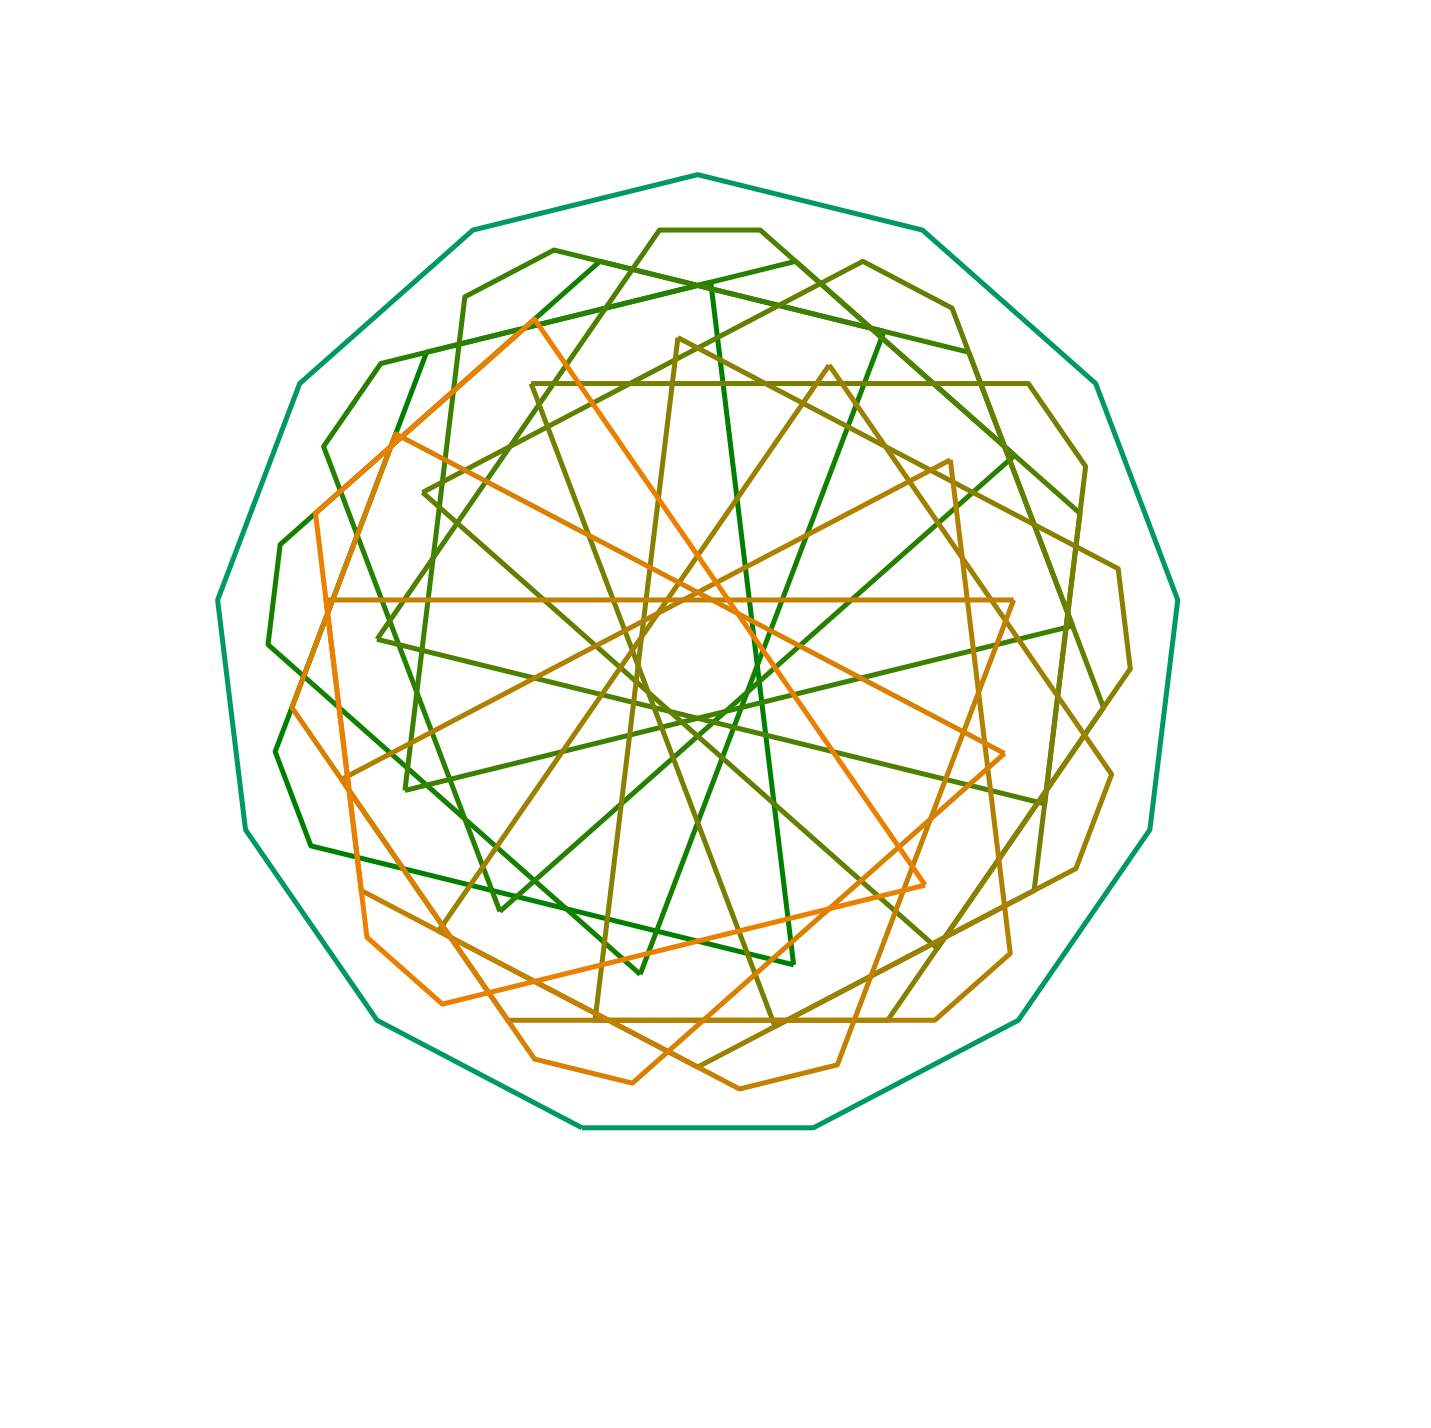

In [44]:
%pylab --no-import-all inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
Path = mpath.Path

def drawPolygon( polygonVerts, color ):
    n = len( polygonVerts )
    codes = [ Path.MOVETO ]
    verts = []
    verts .append( polygonVerts[ 0 ] .render() )
    for i in range(1,n+1):
        codes.append ( Path.LINETO )
        verts.append ( polygonVerts[ i % n ] .render() )
    path = mpath.Path( verts, codes )
    return mpatches.PathPatch( path, facecolor='none', edgecolor=color, linewidth=5.0 )

def drawIntersection( p, a, b, c, d, color ):
    inter = diagonalIntersection( p, a, b, c, d )
    codes = []
    verts = []
    codes .append( Path.MOVETO )
    verts .append( p[ a ] .render() )
    codes .append( Path.LINETO )
    verts .append( inter .render() )
    codes .append( Path.MOVETO )
    verts .append( p[ b ] .render() )
    codes .append( Path.LINETO )
    verts .append( inter .render() )
    codes .append( Path.MOVETO )
    verts .append( p[ c ] .render() )
    codes .append( Path.LINETO )
    verts .append( inter .render() )
    codes .append( Path.MOVETO )
    verts .append( p[ d ] .render() )
    codes .append( Path.LINETO )
    verts .append( inter .render() )
    path = mpath.Path( verts, codes )
    return mpatches.PathPatch( path, facecolor='none', edgecolor=color )

fig = plt.figure(figsize=(25,25))

ax = fig.add_subplot(111)

ax.set_xlim(-10,15)
ax.set_ylim(-5,20)

for i in range(2):
    ax.add_patch( drawPolygon( triskaidecagrams[i], (0,0.6,0.4) ) )

#ax.add_patch( drawIntersection( p, 1, 5, 6, 3, '#434f00' ) )

N = len( p )
loop = diagonalIntersectionLoop( N )
for i in range( N ):
    ax.add_patch( drawPolygon( loopPoints( loop, i, N ), ( float(i)/float(N), 0.5, 0.0) ) )

ax.axis('off')
#fig.savefig( "triskaidecagon-exp01.pdf" )


## The Skew Coordinates